In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers as kl
import numpy as np 
import pandas as pd 
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [3]:
dftrain = pd.read_csv('/content/drive/MyDrive/dataset/mitbih_train (1).csv',header=None)
dftest = pd.read_csv('/content/drive/MyDrive/dataset/mitbih_test (1).csv',header=None)

In [4]:
Xtrain  = dftrain.iloc[:,:-1].astype(float).to_numpy()
Diagtrain = dftrain.iloc[:,187].astype(int)
Xtest  = dftest.iloc[:,:-1].astype(float).to_numpy()
Diagtest = dftest.iloc[:,187].astype(int)
print(Diagtrain.value_counts())
print(Diagtest.value_counts())

Ytrain = pd.get_dummies(Diagtrain).to_numpy()
Ytest = pd.get_dummies(Diagtest).to_numpy()
print(Xtrain.shape)
print(Ytrain.shape)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64
0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64
(87554, 187)
(87554, 5)


In [5]:
sc = StandardScaler()

XtrainNorm = sc.fit_transform(Xtrain)
XtestNorm = sc.transform(Xtest)

In [6]:
tf.keras.backend.clear_session()

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):  
        if(logs.get('val_loss')<0.063):
          self.model.stop_training = True

def train(X,Y,E,BS):
  callback = MyCallback()
  skips = []
  inp = kl.Input(shape=( 187))
  x = kl.Reshape(( 187, 1))(inp)
  dilatation_rates = [2**k for k in range(7)]
  print(dilatation_rates)
  for i in dilatation_rates:
    
    x = kl.TimeDistributed(kl.Dense(64, activation = 'relu'))(x)
    x_f = kl.Conv1D(64,2, strides=1,dilation_rate = i, padding = "causal", activation = "relu")(x)
    x_g = kl.Conv1D(64,2, strides=1,dilation_rate = i, padding = "causal", activation = "relu")(x)
    
    y = kl.Multiply()([kl.Activation('tanh')(x_f), kl.Activation('sigmoid')(x_g)])
   
    y = kl.TimeDistributed(kl.Dense(64, activation = 'relu'))(y)
    
    #z = kl.Add()([x, y])    
    
    skips.append(y)
 
  #x = tf.compat.v1.keras.layers.CuDNNLSTM(32, return_sequences = False)(x)
  #x = kl.TimeDistributed(kl.Dense(64, activation = "relu"))(x)
    
  #x = kl.TimeDistributed(kl.Dense(64, activation = "relu"))(x)
  #x = kl.TimeDistributed(kl.Dense(32, activation = "relu"))(x)
  #x = kl.TimeDistributed(kl.Dense(16, activation = "relu"))(x)
  a = kl.Activation('relu')(kl.Add()(skips))
  a = kl.Flatten()(a)
  a = kl.Dropout(0.2)(a)
  a = kl.Dense(512, activation = "relu")(a)
  a = kl.Dropout(0.1)(a)
  a = kl.Dense(64, activation = "relu")(a)
  
  out = kl.Dense(5, activation = "softmax")(a)
  


  model = tf.keras.Model(inputs=inp, outputs=out, name="cardiowave")

  model.summary() 
  #optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
  loss = tf.keras.losses.CategoricalCrossentropy()

  model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"]) 
  history = model.fit(X, Y, 
                      shuffle = True,
                      epochs=E,
                      validation_data = (Xtest,Ytest),
                      batch_size=BS
                      , callbacks=[callback])
  return model, history
E = 20
model, history = train(Xtrain,Ytrain,E, 64)

[1, 2, 4, 8, 16, 32, 64]
Model: "cardiowave"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 187, 1)       0           ['input_1[0][0]']                
                                                                                                  
 time_distributed (TimeDistribu  (None, 187, 64)     128         ['reshape[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_2 (TimeDistri  (None, 187, 64)     4160       

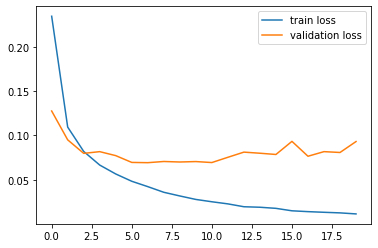

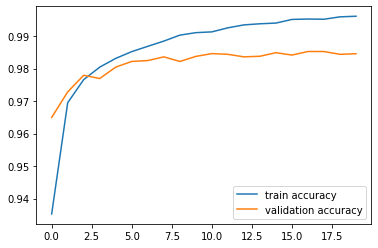

In [7]:
N = len(history.history["loss"])

fig, ax = plt.subplots()
ax.plot(range(N), history.history["loss"], label = "train loss")
ax.plot(range(N), history.history["val_loss"], label = "validation loss")
ax.legend()

fig, ax = plt.subplots()
ax.plot(range(N), history.history["accuracy"], label = "train accuracy")
ax.plot(range(N), history.history["val_accuracy"], label = "validation accuracy")
ax.legend()

In [8]:
pred = model.predict(Xtest)
predlabel = np.argmax(pred, axis = 1)
count = sum(sum([predlabel == Diagtest.to_numpy()]))

print(str(len(predlabel)-count) + " mauvais diagnostiques")
print(str((1 - (len(predlabel)-count)/(len(predlabel)))*100) + "% de bons diagnostiques")


print(Diagtest[predlabel != Diagtest.to_numpy()].value_counts())

685/685 [==============================] - 4s 5ms/step
338 mauvais diagnostiques
98.45605700712589% de bons diagnostiques
1    140
2     77
0     62
3     35
4     24
Name: 187, dtype: int64


In [9]:
score = f1_score( Diagtest, predlabel, average='macro')
print(score)

0.9143738947391178


In [12]:
from sklearn.metrics import confusion_matrix

Normalized confusion matrix


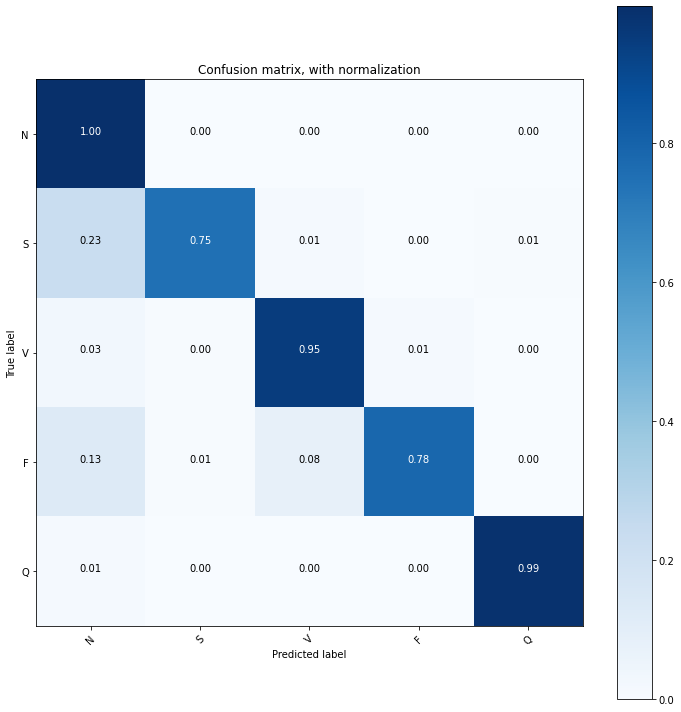

In [16]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(Ytest.argmax(axis=1), pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()